In [7]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn import linear_model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, mean_squared_error, r2_score, roc_auc_score, roc_curve

#import shap
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
import seaborn as sns

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

from math import sqrt

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [8]:
hospital_table_3 = pd.read_csv(r"C:\Users\amirf\Downloads\hospital_table_3.csv",parse_dates=['Date'], index_col='Date')
hospital_table_3.head()

,hospitalized,% hospitalized women,avg age hospitalized,respirated,% women on a respirator,avg age on a respirator,% unvaccinated on a respirator,mild sick,%mild sick women,% mild sick unvaccinated,avg mild sick,moderate sick,% women moderate sick,unvaccinated moderate sick,avg age moderate sick,critical sick,% critical sick women,% unvaccinated critical sick,avg age critical sick
Date,,,,,,,,,,,,,,,,,,,
2020-03-11,79,45.6,47.8,7.0,40.0,63.8,100.0,72.0,45.8,100.0,46.2,0.0,0.0,0.0,0.0,6.0,50.0,100.0,67.3
2020-03-12,102,49.0,49.9,2.0,40.0,63.8,100.0,95.0,49.5,100.0,48.9,0.0,0.0,0.0,0.0,1.0,50.0,100.0,67.3
2020-03-13,120,47.5,49.2,8.0,40.0,63.8,100.0,109.0,47.7,100.0,47.3,6.0,40.0,100.0,68.0,3.0,50.0,100.0,67.3
2020-03-14,158,49.4,47.4,12.0,0.0,70.3,100.0,148.0,50.7,100.0,45.7,2.0,40.0,100.0,68.0,10.0,20.0,100.0,76.8
2020-03-15,197,51.8,46.5,6.0,20.0,74.0,100.0,183.0,52.5,100.0,44.6,10.0,50.0,100.0,61.3,8.0,37.5,100.0,79.0


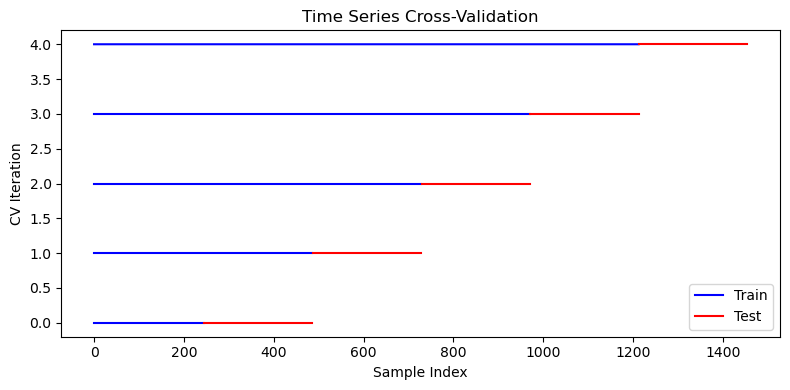

In [9]:
# Example - a visual representation of how TimeSeriesSplit works. 
# Each fold uses a progressively larger training set and a future time period for testing.
df = hospital_table_3.copy()

# Create lag features to serve as your feature matrix X
df['lag_1'] = df['respirated'].shift(1)
df['lag_2'] = df['respirated'].shift(2)
df['lag_3'] = df['respirated'].shift(3)

# Drop NaN values due to lagging
df = df.dropna()

# Define X (features) and y (target variable)
X = df[['lag_1', 'lag_2', 'lag_3']]  # Feature matrix: lagged values
y = df['respirated']  # Target variable

# Apply TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Visualization of Time Series Cross-Validation
fig, ax = plt.subplots(figsize=(8, 4))

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    ax.plot(train_index, [i] * len(train_index), 'b-', label='Train' if i == 0 else '')
    ax.plot(test_index, [i] * len(test_index), 'r-', label='Test' if i == 0 else '')

ax.set_title('Time Series Cross-Validation')
ax.set_xlabel('Sample Index')
ax.set_ylabel('CV Iteration')
ax.legend()
plt.tight_layout()
plt.show()

In [14]:
# Chronological split of data into train and test sets
split_index = int(len(X) * 0.7)  # 70% of data for training
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Define the XGBoost model
model = XGBRegressor(random_state=42)

# Define the hyperparameter search space
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Create a TimeSeriesSplit object for time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search object on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and best hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model's performance on the test set
y_pred = best_model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Best Hyperparameters: {best_params}")
print(f"Test Set Mean Squared Error: {rmse:.4f}")

OSError: [Errno 22] Invalid argument

In [10]:
# arima model

import itertools

def arima_objective_function(p_values, d_values, q_values, trend_values):

    global n, ntrain, data_train, data_test
    
    params_evaluated = []
    results = []

    # Generate all combinations of p, d, q, and trend
    param_combinations = list(itertools.product(p_values, d_values, q_values, trend_values))

    for p, d, q, trend in param_combinations:
        params = {'p': p, 'd': d, 'q': q, 'trend': trend}
        
        try:
            # Fit ARIMA model with given parameters
            model = ARIMA(data_train, order=(p, d, q), trend=trend).fit()
            y_pred = model.predict(start=ntrain, end=n-1)

            # Calculate root mean squared error
            rmse = sqrt(mean_squared_error(data_test, y_pred))
            params_evaluated.append(params)
            results.append(rmse)
            #print(p, d, q, trend, rmse)
        except:
            # If an exception is raised, add a large error as a penalty
            # print(p, d, q, trend)
            # try:
            #     print(f"Error with parameters (p={p}, d={d}, q={q}, trend={trend}): {e}")
            # except:
            #     print("Error", p, d, q, trend)
            params_evaluated.append(params)
            results.append(1e5)
            continue

    return params_evaluated, results, y_pred

In [11]:
# Define your ranges for p, d, q, and trend values
p_values = [0, 1, 2, 3, 8, 13]
d_values = [0, 1, 2]
q_values = [0, 1, 2]
trend_values = ['n', 'c', 't']

# Run the grid search
evaluated_params, rmse_results, y_pred = arima_objective_function(p_values, d_values, q_values, trend_values)

# Find the best parameters based on minimum MSE
best_index = rmse_results.index(min(rmse_results))
best_params = evaluated_params[best_index]
best_rmse = rmse_results[best_index]

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

UnboundLocalError: cannot access local variable 'y_pred' where it is not associated with a value

In [5]:
y_pred.shape

NameError: name 'y_pred' is not defined